<a href="https://colab.research.google.com/github/YMuskrat/Sentiment-Classification/blob/master/NLassignment2021.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#do not change the code in this cell
#preliminary imports

#set up nltk
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('movie_reviews')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.corpus import movie_reviews

#for setting up training and testing data
import random

#useful other tools
import re
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from itertools import zip_longest
from nltk.probability import FreqDist
from nltk.classify.api import ClassifierI


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package movie_reviews to /root/nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!


In [ ]:
#do not change the code in this cell
def split_data(data, ratio=0.7): # when the second argument is not given, it defaults to 0.7
    """
    Given corpus generator and ratio:
     - partitions the corpus into training data and test data, where the proportion in train is ratio,

    :param data: A corpus generator.
    :param ratio: The proportion of training documents (default 0.7)
    :return: a pair (tuple) of lists where the first element of the 
            pair is a list of the training data and the second is a list of the test data.
    """
    
    data = list(data)  
    n = len(data)  
    train_indices = random.sample(range(n), int(n * ratio))          
    test_indices = list(set(range(n)) - set(train_indices))    
    train = [data[i] for i in train_indices]           
    test = [data[i] for i in test_indices]             
    return (train, test)                       
 

def get_train_test_data():
    
    #get ids of positive and negative movie reviews
    pos_review_ids=movie_reviews.fileids('pos')
    neg_review_ids=movie_reviews.fileids('neg')
   
    #split positive and negative data into training and testing sets
    pos_train_ids, pos_test_ids = split_data(pos_review_ids)
    neg_train_ids, neg_test_ids = split_data(neg_review_ids)
    #add labels to the data and concatenate
    training = [(movie_reviews.words(f),'pos') for f in pos_train_ids]+[(movie_reviews.words(f),'neg') for f in neg_train_ids]
    testing = [(movie_reviews.words(f),'pos') for f in pos_test_ids]+[(movie_reviews.words(f),'neg') for f in neg_test_ids]
   
    return training, testing

When you have run the cell below, your unique training and testing samples will be stored in `training_data` and `testing_data`

In [ ]:
#do not change the code in this cell
random.seed(candidateno)
training_data,testing_data=get_train_test_data()
print("The amount of training data is {}".format(len(training_data)))
print("The amount of testing data is {}".format(len(testing_data)))
print("The representation of a single data item is below")
print(training_data[0])

The amount of training data is 1400
The amount of testing data is 600
The representation of a single data item is below
(['not', 'since', 'attending', 'an', 'ingmar', ...], 'pos')


**QUESTION 1**

a) **Generate** a list of 10 content words which are representative of the positive reviews in your training data.

b) **Generate** a list of 10 content words which are representative of the negative reviews in your training data.

c) **Explain** what you have done and why

[20\%]

**Snippet From our Training data**

In [ ]:
print(list(training_data[0][0]))

['not', 'since', 'attending', 'an', 'ingmar', 'bergman', 'retrospective', 'a', 'few', 'years', 'ago', 'have', 'i', 'seen', 'a', 'film', 'as', 'uncompromising', 'in', 'its', 'portrayal', 'of', 'emotional', 'truth', 'as', 'secrets', '&', 'lies', '.', 'like', 'bergman', ',', 'director', 'mike', 'leigh', 'is', 'interested', 'in', 'probing', 'his', 'characters', "'", 'inner', 'depths', 'through', 'hypernaturally', 'blunt', 'confrontations', '.', 'also', 'like', 'bergman', ',', 'leigh', 'engages', 'in', 'frequent', 'closeups', 'of', 'his', 'characters', "'", 'ravished', 'and', 'wracked', 'faces', '.', 'and', 'the', 'prominent', 'mournfulness', 'of', 'a', 'cello', 'on', 'the', 'soundtrack', 'recalls', 'bergman', "'", 's', 'own', 'use', 'of', 'a', 'bach', 'cello', 'suite', 'in', 'an', 'earlier', 'film', '.', 'all', 'that', 'is', 'missing', 'is', 'a', 'discussion', 'of', 'god', '.', 'which', 'is', 'not', 'to', 'say', 'that', 'secrets', '&', 'lies', 'is', 'nothing', 'more', 'than', 'an', 'homage

**Normalising data**

Our data is split into 30% Test and 70% training, However, it not normalised yet. We could notice in the code cell above that there is still some stopwords and not alphabetic words in our **training** and **testing** data. Therefore we have to pre-process our data using the **`normalise`** function before working with it. Since the goal of our application is to classify **positive** and **negative** reviews, we won't need to dinstinguish between uppercase or lower case words and numbers( we do not need symbols as well) would be irrelevant in the classification of our document. Having done so, we would reduce redundancy and duplicates data. 

In [ ]:
stop = stopwords.words('english') #getting stops from English dic
# normalise the worlist
def normalise(wordlist):
    lowered=[word.lower() for word in wordlist if word.isalpha() and word not in stop]
    return lowered

In [ ]:
training_norm=[(FreqDist(normalise(wordlist)),label) for (wordlist,label) in training_data] #store the normalized training data
testing_norm=[(FreqDist(normalise(wordlist)),label) for (wordlist,label) in testing_data] # store the normalized testing data

**BAG OF WORDS REPRESENTATION**

Using raw text in NLP is impossible, therefore we have to extract features from our data/text. Since we are dealing with document classification, we can discard the order of the words and  only count the occurences of words since similar documents should have more or less same words. we used a library funciton called FreqDist from nltk.probability which will generate our bag of words.

In [ ]:
pos_freq_dist= FreqDist()
neg_freq_dist= FreqDist()
def Bag_of_words(Training_data):  #Bag of words representation
  global pos_freq_dist,neg_freq_dist #define var
  for reviewDist,label in Training_data:
     if label=='pos':
        pos_freq_dist+=reviewDist #store positive reviews
     else:
        neg_freq_dist+=reviewDist #store negative reviews
  return (pos_freq_dist, neg_freq_dist)

Here, is the output of our positve and negative frequenecy distribution or the bag of words representation in the normalised training data.

In [ ]:
pos_freq, neg_freq = Bag_of_words(training_norm) # convert the normalised data to a bag of words.
pos_freq

FreqDist({'since': 266,
          'attending': 6,
          'ingmar': 3,
          'bergman': 13,
          'retrospective': 2,
          'years': 336,
          'ago': 67,
          'seen': 389,
          'film': 3667,
          'uncompromising': 6,
          'portrayal': 51,
          'emotional': 116,
          'truth': 72,
          'secrets': 19,
          'lies': 59,
          'like': 1239,
          'director': 407,
          'mike': 56,
          'leigh': 17,
          'interested': 42,
          'probing': 1,
          'characters': 704,
          'inner': 18,
          'depths': 11,
          'hypernaturally': 1,
          'blunt': 5,
          'confrontations': 4,
          'also': 855,
          'engages': 8,
          'frequent': 13,
          'closeups': 1,
          'ravished': 1,
          'wracked': 1,
          'faces': 31,
          'prominent': 14,
          'mournfulness': 1,
          'cello': 4,
          'soundtrack': 60,
          'recalls': 6,
          'use':

**GENERATING TOP 10 WORDS**

After we normalised and we extracted the features from our training data using the bag words representation we define our `top_10`  function which takes our negative frequency distribution and positive distribution  and outputs k words in our case 10. 

The funciton takes  **three arguments**  two frequency distributions and a number which denotes the number of words to be taken from the pool of candidates of the most ferquent  words.  In other words, it order the words on how much they occur more in one of the frequencies distribution and then return the hightest scoring words in our case it is 10

In [ ]:
def top_10(pos, neg, topk): #find most frequent words 
  diff= pos-neg
  sorted_diff= diff.most_common()
  words=[word for (word,freq) in sorted_diff[:topk]]
  return words

`TopPos` stores our top 10 words denoting **positive reviews**

In [ ]:
TopPos=top_10(pos_freq, neg_freq, 10)
TopPos

['film',
 'life',
 'also',
 'great',
 'well',
 'story',
 'best',
 'world',
 'many',
 'films']

`TopNeg` stores our top 10 words denoting **negative reviews**

In [ ]:
TopNeg=top_10(neg_freq,pos_freq,  10)
TopNeg

['bad',
 'movie',
 'plot',
 'worst',
 'even',
 'boring',
 'script',
 'get',
 'stupid',
 'big']

**2)QUESTION 2**

a) **Use** the lists generated in Q1 to build a **word list classifier** which will classify reviews as being positive or negative.

b) **Explain** what you have done.

[12.5\%]


**WORD CLASSIFIER**

Since we have created our `TopPos` and `TopNeg` word lists we can define our word list classifier to classify our documents. 

In the cell below we define our word list classifier. Our word classifier class has three functions. In **`_init_`** we initialize the negative and positive word lists. Our **`classify`** function which takes words of a document and returns to which class the given document belongs to. It decrements the score by the word value whenever there is an occurence of a negative word and incerement by the word value if an occurence of a positive word is seen. If the score is negative the document is a negative review, and if it the score is positive then the document is in the positive class



In [ ]:
from nltk.classify.api import ClassifierI
import random

class Word_Classifier(ClassifierI):
  def __init__(self, pos, neg): 
        self._pos = pos 
        self._neg = neg 

  def classify(self, doc): 
        score = 0
        
        for word,value in doc.items():
          if word in self._pos:
            score+=value
          if word in self._neg:
            score -=value
        # add code here that assigns an appropriate value to score
        return "neg" if score < 0 else "pos"

    ##we don't actually need to define the classify_many method as it is provided in ClassifierI
    #def classify_many(self, docs): 
    #    return [self.classify(doc) for doc in docs] 

  def labels(self): 
        return ("pos", "neg")

In the cell below, we pass the `TopPos` and `TopNeg` word lists to train our classifier and once done we pass the sentence as a bag of words to the classify method, to classify its class.


In [ ]:
Classifier_=Word_Classifier(TopPos,TopNeg) #Train our classifier
Classifier_.classify(FreqDist("This movie was great".split())) #Classify the sentence just for testing

'pos'

We used the `zip(*testing_norm)` function to split our normalised test data into pairs of lists, `docs` and `labels`. where `docs` is the bag of word representation

In [ ]:
docs,labels=zip(*testing_norm) #  split our testing data


In the cell below, we pass docs which is the bag of words representation of the testing data to our classifier to determine the documents classes.

In [ ]:
word_list_classifier_result=Classifier_.classify_many(docs) # Classify our Test Data
word_list_classifier_result #Print the prediction reults

['pos',
 'pos',
 'pos',
 'neg',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'neg',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'neg',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'neg',
 'neg',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'neg',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'neg',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'neg',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'neg',
 'pos',
 'neg',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'neg',
 'pos',
 'pos',
 'pos',
 'neg',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'neg',
 'pos',
 'pos',
 'pos',


**3)QUESTION 3**

a) **Calculate** the accuracy, precision, recall and F1 score of your classifier.

b) Is it reasonable to evaluate the classifier in terms of its accuracy?  **Explain** your answer and give a counter-example (a scenario where it would / would not be reasonable to evaluate the classifier in terms of its accuracy).

[20\%]

**Confusion Matrix**

The confusion matrix below calculates the True positive, True negatice, False positive and False negative of the predictions of our data.

In [ ]:
class ConfusionMatrix:
    def __init__(self,predictions,goldstandard,classes=("pos","neg")):
    
        (self.c1,self.c2)=classes
        self.TP=0
        self.FP=0
        self.FN=0
        self.TN=0
        for p,g in zip(predictions,goldstandard):
            if g==self.c1:
                if p==self.c1:
                    self.TP+=1
                else:
                    self.FN+=1
        
            elif p==self.c1:
                self.FP+=1
            else:
                self.TN+=1
        
    
    def accuracy(self):
      a=0

      a = (self.TP+self.TN)/(self.TP+self.TN+self.FP+self.FN)
      return a

    def precision(self):
        p=0
        #put your code to compute precision here
        p = self.TP / (self.TP + self.FP)
    
        return p
    
  
    def recall(self):
        r=0
        #put your code to compute recall here
        r= self.TP/(self.TP + self.FN)
        return r
  
    def f1(self):
        f1=0
        #put your code to compute f1 here
        f1= 2 * (self.recall()*self.precision()/(self.recall()+self.precision()))
        return f1 

In [ ]:
score=ConfusionMatrix(Classifier_.classify_many(docs),labels) #calculate the score for the different evaluation method when classifying our testing data

The code below displayes the score of each of the evaluation method using the prediction over our test data

In [ ]:
from tabulate import tabulate
print(tabulate([['accuracy', score.accuracy()], ['precision', score.precision()],['recall', score.recall()], ['F1_score', score.f1()]],headers=['Name', 'score'])) #print the score of the different evaluation methods into a table

Name          score
---------  --------
accuracy   0.656667
precision  0.611905
recall     0.856667
F1_score   0.713889


**ACCURACY**

Accuracy basically the proportion of documents that were classified correctly over the total number of predictions.

Evaluating the classifier ONLY in terms of accuracy is not a reasonable thing to do for several reasons (However, Accuracy might comes in handy for our project needs and goals, but in general it is a misleading type of evaluation). Also, in our case the classes are balanced, so accuracy is useful in our case.



*   Accuracy can be misleading when the classes are unbalanced.For instance, if we have to classify our documents to two classes A and B, and we have 20% of documents in our Class A and 80% in our class B. The classifier that will classify all the documents as being class B will score 80%, which is a good score, but not reliable our classifier will keep oscillating between Big different accuracies ( For example, 20% accuracy if it classifies everything as A and will oscillate quickly if it classifies everything as class B).
In other words, we can lower the cost and have greater accuracy just by predicting that every doc/data belongs to the majority class, and **clearly** that is not reliable and certain predictions can bypass the accuracy metric and mislead us.



**4) QUESTION 4**

a)  **Construct** a Naive Bayes classifier (e.g., from NLTK).

b)  **Compare** the performance of your word list classifier with the Naive Bayes classifier.  **Discuss** your results. 

[12.5\%]

**NAIVE BAYES CLASSIFIER**

We will use the standard Naive Bayes classifier imported from nltk.classify.

Once imported we can train our model using the train method and pass to it the bag words representation of our training data.

In [ ]:
from nltk.classify import NaiveBayesClassifier #import the naive bayes classifier

nltk_nb=NaiveBayesClassifier.train(training_norm)

In the cell below, we pass the testing data to classify using our naive bayes classifier.

In [ ]:
Naive_bayes_results=nltk_nb.classify_many(docs) #store the classification results in the variable
Naive_bayes_results

['pos',
 'pos',
 'pos',
 'pos',
 'neg',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'neg',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'neg',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'neg',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'neg',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'neg',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'neg',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',


In the cell below, we calculate the difference evaluation scores for our naive bayes classifier

In [ ]:
NB_score=ConfusionMatrix(nltk_nb.classify_many(docs),labels)
print(tabulate([['accuracy', NB_score.accuracy()], ['precision', NB_score.precision()],['recall', NB_score.recall()], ['F1_score', NB_score.f1()]],headers=['Name', 'score']))

Name          score
---------  --------
accuracy   0.725
precision  0.651007
recall     0.97
F1_score   0.779116


**Comparison**

The above evaluation for the Naive bayes algorithm is when we train our classifier on 700 by 700 data of negative and positive reviews respectiveley.

The evaluation we had for the word classifier was only 10 by 10 words list to train our classifier.

To have a more robust comparision between the wordlist and the Naive Bayes classifier we should compare it while using the same amount of training data. In the cell below I will compare both classifiers using 1, 20, 100, 400, 700 training data split to feed to our classifier.

In [ ]:
from random import sample
sample_sizes=[1,20,100,400,700] # Define different sample sizes

total_dict_result={} # store the data in a dictionary for both Naive based classifier and Word list classifier
for size in sample_sizes:
  WC_res={} # store the accuracy result for Word list
  NB_res={} #sote the accuracy result for the Naive bayes result

  positive_training=[(doc,label) for (doc,label) in training_norm if label=="pos"] # Store normalised positive data
  negative_training=[(doc,label) for (doc,label) in training_norm if label=="neg"] # Store normalised negative data

  Positive_data=top_10(pos_freq, neg_freq, size) # generate the positive data with a certain size
  Negative_data= top_10(neg_freq,pos_freq, size) # generate the negative data with a certain size

  training_sample=sample(positive_training,size)+sample(negative_training,size) # randomizing the data choosing

  Naive_Bayes_Classifier=NaiveBayesClassifier.train(training_sample) #Training the Naive Bayes 

  W_Classifier=Word_Classifier(Positive_data,Negative_data) # Training the Word List classifier

  Word_Classifier_score=ConfusionMatrix(W_Classifier.classify_many(docs),labels).accuracy() # calculate the accuracy for the word list classifier

  Naive_Bayes_score= ConfusionMatrix(Naive_Bayes_Classifier.classify_many(docs),labels).accuracy() # calculate the accuracy for the Naive Bayes classifier
  
  #storing accuracy scores
  WC_res["Word Classifiers"]=Word_Classifier_score 
  NB_res["Naive Bayes classifier"] =Naive_Bayes_score
  
  #storing both accuracy scores in a nesteed dictionary
  total_dict_result[size]=WC_res
  total_dict_result[size].update(NB_res)


In [ ]:
total_dict_result # Displaying our nested dictionary

{1: {'Naive Bayes classifier': 0.5283333333333333,
  'Word Classifiers': 0.5416666666666666},
 20: {'Naive Bayes classifier': 0.5766666666666667, 'Word Classifiers': 0.68},
 100: {'Naive Bayes classifier': 0.745,
  'Word Classifiers': 0.6416666666666667},
 400: {'Naive Bayes classifier': 0.7116666666666667,
  'Word Classifiers': 0.665},
 700: {'Naive Bayes classifier': 0.725,
  'Word Classifiers': 0.6616666666666666}}

In [ ]:
df1=pd.DataFrame(total_dict_result)
df1=df1.transpose()
df1

,Word Classifiers,Naive Bayes classifier
1,0.541667,0.528333
20,0.680000,0.576667
100,0.641667,0.745000
400,0.665000,0.711667
700,0.661667,0.725000


Text(0.5, 0, 'Sample Size')

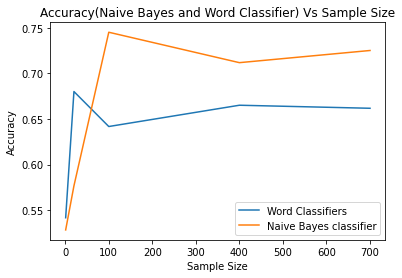

In [ ]:
ax = df1.plot(kind="line",title="Accuracy(Naive Bayes and Word Classifier) Vs Sample Size")
ax.set_ylabel("Accuracy")
ax.set_xlabel("Sample Size")

**Discussion**

We have run both of our classifier over multiple sizes of data, and from the experiment we could see that in general Naive Bayes classifier is better than the word list classifier.

When the data fed to our classifier the word classifier proformed slightly better than the Naive bayes, but once we added more and more training, Naive bayes jumped by a big margin and kept rising while the Word classifier started decreasing at the end

**5) QUESTION 5**

a) Design and **carry out an experiment** into the impact of the **length of the wordlists** on the wordlist classifier.  Make sure you **describe** design decisions in your experiment, include a **graph** of your results and **discuss** your conclusions. 

b) Would you **recommend** a wordlist classifier or a Naive Bayes classifier for future work in this area?  **Justify** your answer.

[25\%]


**IMPACT OF LENGTH OF WORDLISTS ON THE WORD LIST CLASSIFIER**

Basically, we will explore the impact of the quantity of our training data on the performance of our Word List classifier.

In the code below, we have used samples of 1, 10, 50 to 700 data sizes.  

*   We have 700 positive training reviews and 700 negative which makes our training balanced, which is why we should stop at the maximum of 700, othewise it will be unbalanced. In other words, we selected samples that have equal positive and negative reviews.
*   We have used the random sample to generate random reviews and we have averaged them over the number of runs which we chose to be 3. we could have chose whaterver number of runs, the more the accurate, but we would stick with 3 just for the sake of demonstration.


*   the function top_10 generates for us the negative and positive reviews of different sizes which we use to train our classifier on, and we calculate the accuracy accordinly. we have used the accuracy as a metric, since there wouldnt be much of a drawback or misleading as our training data is balanced.






In [ ]:
from random import sample

sample_sizes=[1,10,50,100,200,400,600, 700] # data sizes samples
Names = {"Word Classifiers"} 
results={} # Dict for storing our accuracy results
number_of_runs=3

for size in sample_sizes: # Loop arund the sample sizes
    res={}
    for i in range(number_of_runs): # For each size we run it 3 times
       Pos=random.sample(top_10(pos_freq, neg_freq, size),size) # generating the positive review (bag of words rep)
       Neg= random.sample(top_10(neg_freq,pos_freq, size),size) #generating the negative reviews ( bag of words rep)
       for name in  Names:
        Classifying=Word_Classifier(Pos,Neg) # Train our word list classifier
        score1=ConfusionMatrix(Classifying.classify_many(docs),labels).accuracy() # calculate the accuracy
        res[name]=score1
    results[size]=res

In the cell below, is the accuracy of our word classifier over the sample size

In [ ]:
df=pd.DataFrame(results)
df=df.transpose()
df

,Word Classifiers
1,0.541667
10,0.656667
50,0.668333
100,0.641667
200,0.663333
400,0.665000
600,0.661667
700,0.661667


**Conclusion**

After, we have plotted our accuracy over the sample size. From the graph below we could clearly see that the accuracy increases when we increase the amount of the training data. When it reach the 100 training data there is a slight decrease, but after it increase and it keeps decreasing very slowly ( probably a decimal point decrease). We can conclude that the increase in the training size could help but not consistent, in contrast, after a certain point it starts to decrease.

Text(0.5, 0, 'Sample Size')

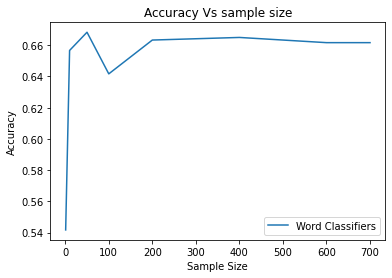

In [ ]:
#Plotting the accuracy over the sample size
ax = df.plot(kind="line",title="Accuracy Vs sample size")
ax.set_ylabel("Accuracy")
ax.set_xlabel("Sample Size")

**Word Classifier VS Naive Bayes Algorithm**

I would recommend the Naive Bayes algorithm oveer the word classifier, as we could clearly see that the Naive Bayes outpreform the word classifier in most of the training data sizes. Even though, the word classifier was better slightly than the Naive bayes but it is not consistent and increasing the amount of training data doesnt help much unlike the Naive bayes algorithm where we could see a massive improvement.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
##This code will word count all of the markdown cells in the notebook saved at filepath
##Running it before providing any answers shows that the questions have a word count of 437

import io
from nbformat import current

filepath='/content/drive/My Drive/PG2021/NLassignment2021.ipynb'
#filepath="NLassignment2021.ipynb"
question_count=437

with io.open(filepath, 'r', encoding='utf-8') as f:
    nb = current.read(f, 'json')

word_count = 0
for cell in nb.worksheets[0].cells:
    if cell.cell_type == "markdown":
        word_count += len(cell['source'].replace('#', '').lstrip().split(' '))
print("Submission length is {}".format(word_count-question_count))

Submission length is 1391
